# **Importing necessary libraries and modules needed for the project**



In [1]:
import numpy as np
import pandas as pd
import cv2
import seaborn as sns
import tensorflow as tf
import random
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline
from sklearn.datasets import load_files       
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
from glob import glob
import keras
from keras.preprocessing import image                  
from tqdm import tqdm
import os, os.path
import imageio
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.utils import class_weight

In [2]:
from google.colab import drive


In [3]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import zipfile

In [5]:
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/data.zip', 'r')
zip_ref.extractall('/input')
zip_ref.close()

In [6]:
train_path= ('../input/train')
test_path= ('../input/test')
val_path=  ('../input/val')


# **Data preprocessing**

In [7]:
#train data preprocessing
CLASSES=["NORMAL","TURBERCULOSIS"]
img_size=150
train_data=[]

for category in CLASSES:
    path=os.path.join(train_path,category)
    label=CLASSES.index(category)
    for img in os.listdir(path):
        img_path=os.path.join(path,img)
        img_array=cv2.imread(img_path)
        img_array=cv2.resize(img_array , (img_size,img_size))
        train_data.append([img_array,label])

In [8]:
random.shuffle(train_data)

In [9]:
len([name for name in os.listdir(train_path + "/NORMAL/") if os.path.isfile(os.path.join(train_path + "/NORMAL/", name))])


1341

In [10]:
len([name for name in os.listdir(train_path + "/TURBERCULOSIS/") if os.path.isfile(os.path.join(train_path + "/TURBERCULOSIS/", name))])


650

In [11]:
X_train = []
Y_train = []

In [12]:
#Append method appends an element to the end of a list(adds a list to a list)
for features , label in train_data:
  X_train.append(features)
  Y_train.append(label) 
#provide an array object for the specified values
X_train=np.array(X_train)
Y_train=np.array(Y_train)




In [13]:
#displaying array values for the first 20 images
Y_train[:20]

array([0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1])

In [14]:
X_train = X_train/255


In [15]:
X_train

array([[[[0.25098039, 0.25098039, 0.25098039],
         [0.50980392, 0.50980392, 0.50980392],
         [0.48235294, 0.48235294, 0.48235294],
         ...,
         [0.00784314, 0.00784314, 0.00784314],
         [0.00784314, 0.00784314, 0.00784314],
         [0.00784314, 0.00784314, 0.00784314]],

        [[0.25490196, 0.25490196, 0.25490196],
         [0.41176471, 0.41176471, 0.41176471],
         [0.5254902 , 0.5254902 , 0.5254902 ],
         ...,
         [0.01176471, 0.01176471, 0.01176471],
         [0.01176471, 0.01176471, 0.01176471],
         [0.01176471, 0.01176471, 0.01176471]],

        [[0.25490196, 0.25490196, 0.25490196],
         [0.29803922, 0.29803922, 0.29803922],
         [0.56078431, 0.56078431, 0.56078431],
         ...,
         [0.00784314, 0.00784314, 0.00784314],
         [0.00392157, 0.00392157, 0.00392157],
         [0.01176471, 0.01176471, 0.01176471]],

        ...,

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]

In [16]:
X_train.shape

(1991, 150, 150, 3)

# **Training the model**

In [17]:
def sensitivity(y_true, y_pred):
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
  true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
  possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
  return true_negatives / (possible_negatives + K.epsilon())

def fmed(y_true, y_pred):
  spec = specificity(y_true, y_pred)
  sens = sensitivity(y_true, y_pred)
  fmed = 2 * (spec * sens)/(spec+sens+K.epsilon())
  return fmed

def f1(y_true, y_pred):
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
  precision = true_positives / (predicted_positives + K.epsilon())
  recall = true_positives / (possible_positives + K.epsilon())
  f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
  return f1_val

def generate_model(opt = tf.keras.optimizers.SGD(learning_rate=0.001, nesterov=True)):
    
    model = Sequential()
    model.add(Conv2D(64, (3, 3), input_shape=X_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    
    model.add(Conv2D(64, (3,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))


    model.add(Conv2D(64, (3,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))


    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))    
    
    model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy', sensitivity, specificity, fmed, f1])
    return model

In [19]:
batch_size = 32

model = generate_model(opt = tf.keras.optimizers.SGD(learning_rate=0.001, nesterov=True))
history_val_fmed_sgd = model.fit(
    X_train,Y_train,
    validation_split=0.2,
    epochs=40,
    verbose=1,
        callbacks=[
          EarlyStopping(monitor='val_fmed ', mode="max", verbose=1, patience=50),
          ModelCheckpoint(train_path + '/sgd_val_fmed_model.h5', monitor='val_fmed', mode="max", verbose=1, save_best_only=True)
        ],
    )

Epoch 1/40
50/50 [==============================] - ETA: 0s - loss: 0.6697 - accuracy: 0.6068 - sensitivity: 0.2057 - specificity: 0.8015 - fmed: 0.2862 - f1: 0.2297
Epoch 1: val_fmed improved from -inf to 0.00000, saving model to ../input/train/sgd_val_fmed_model.h5
50/50 [==============================] - 93s 2s/step - loss: 0.6697 - accuracy: 0.6068 - sensitivity: 0.2057 - specificity: 0.8015 - fmed: 0.2862 - f1: 0.2297 - val_loss: 0.6477 - val_accuracy: 0.6692 - val_sensitivity: 0.0000e+00 - val_specificity: 1.0000 - val_fmed: 0.0000e+00 - val_f1: 0.0000e+00
Epoch 2/40
50/50 [==============================] - ETA: 0s - loss: 0.6455 - accuracy: 0.6690 - sensitivity: 0.1187 - specificity: 0.9368 - fmed: 0.1987 - f1: 0.1797
Epoch 2: val_fmed did not improve from 0.00000
50/50 [==============================] - 96s 2s/step - loss: 0.6455 - accuracy: 0.6690 - sensitivity: 0.1187 - specificity: 0.9368 - fmed: 0.1987 - f1: 0.1797 - val_loss: 0.6284 - val_accuracy: 0.6692 - val_sensitivity

# **Plotting the model perfomance**

dict_keys(['loss', 'accuracy', 'sensitivity', 'specificity', 'fmed', 'f1', 'val_loss', 'val_accuracy', 'val_sensitivity', 'val_specificity', 'val_fmed', 'val_f1'])


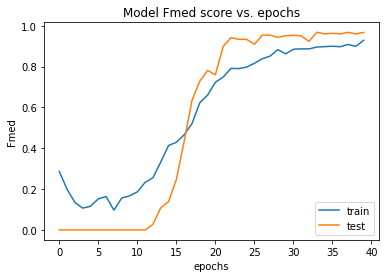

In [20]:
history = history_val_fmed_sgd
print(history.history.keys())

# summarize history for fmed score
plt.plot(history.history['fmed'])
plt.plot(history.history['val_fmed'])
plt.title('Model Fmed score vs. epochs')
plt.ylabel('Fmed')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

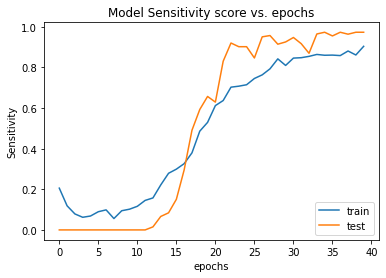

In [21]:
plt.plot(history.history['sensitivity'])
plt.plot(history.history['val_sensitivity'])
plt.title('Model Sensitivity score vs. epochs')
plt.ylabel('Sensitivity')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

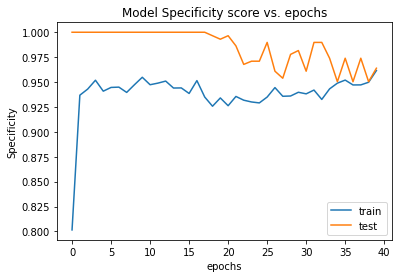

In [22]:
# summarize history for specificity score
plt.plot(history.history['specificity'])
plt.plot(history.history['val_specificity'])
plt.title('Model Specificity score vs. epochs')
plt.ylabel('Specificity')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

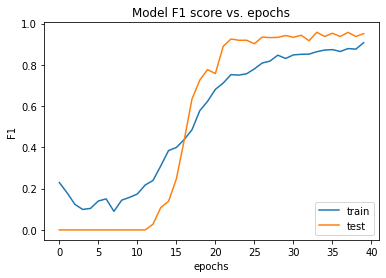

In [23]:
# summarize history for f1 score
plt.plot(history.history['f1'])
plt.plot(history.history['val_f1'])
plt.title('Model F1 score vs. epochs')
plt.ylabel('F1')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

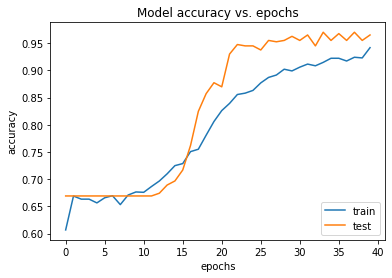

In [24]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy vs. epochs')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

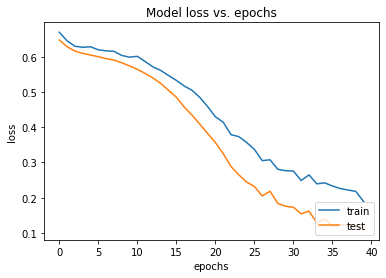

In [25]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss vs. epochs')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

In [26]:
test_gen=ImageDataGenerator()


In [27]:
test_generator = test_gen.flow_from_directory(
        test_path,
        target_size=(img_size, img_size),
        batch_size=32,
        color_mode="rgb",
        class_mode='binary',
        shuffle=False,
        
)

Found 275 images belonging to 2 classes.


In [28]:
model = generate_model(opt=tf.keras.optimizers.SGD(lr=0.001,nesterov=True))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [29]:
model.load_weights(train_path + '/sgd_val_fmed_model.h5')

In [30]:
model.compiled_metrics == None
model.save('3-conv-CNN.h5')

In [31]:
path= '../content/3-conv-CNN.h5'
dependancies={
  'sensitivity':sensitivity,
   'specificity':specificity,
   'fmed':fmed,
    'f1':f1
}
model=tf.keras.models.load_model(
   path,
    custom_objects=dependancies, compile=True, options=None
)

In [32]:
probabilities = model.predict(test_generator)
y_true = test_generator.classes
y_pred = probabilities > 0.5

In [33]:
confusion_matrix(y_true, y_pred)

array([[196,  38],
       [  9,  32]])

In [34]:
test_generator.class_indices

{'NORMAL': 0, 'TURBERCULOSIS': 1}

In [35]:
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

In [36]:
specificity = tn / (tn+fp)
specificity

0.8376068376068376

In [37]:
sensitivity = tp / (tp + fn)
sensitivity


0.7804878048780488

In [38]:
accuracy = (tp + tn) / (tp + fn +fp + tn)
accuracy


0.8290909090909091

# **Plotting the confusion matrix**

In [39]:
cm=confusion_matrix(y_true=test_generator.classes,y_pred=probabilities > 0.5)

In [40]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
  
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
      for j in range (cm.shape[1]):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[196  38]
 [  9  32]]


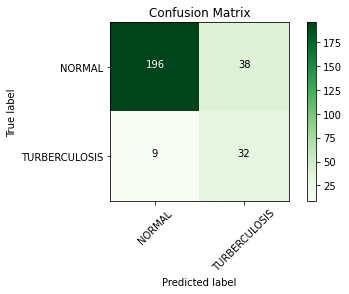

In [41]:
cm_plot_labels=['NORMAL','TURBERCULOSIS']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')